# Independent Filters Experiment Results

In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

/u3/z3tu/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
sns.set_style("whitegrid")

In [4]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-independent-filters-fix-params-and-seed',))]

In [5]:
len(experiment_rows)

42

In [6]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_independent_filters':
        arch = 'Independent Filters'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [7]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [8]:
trecqa.head(8)

,arch,dataset,metric_name,metric_val,seed,split
0,MP-CNN,trecqa,MAP,0.7867,801724,dev
1,MP-CNN,trecqa,MRR,0.8407,801724,dev
2,MP-CNN,trecqa,MAP,0.7897,801724,test
3,MP-CNN,trecqa,MRR,0.8274,801724,test
4,MP-CNN,trecqa,MAP,0.7934,380469,dev
5,MP-CNN,trecqa,MRR,0.8465,380469,dev
6,MP-CNN,trecqa,MAP,0.7746,380469,test
7,MP-CNN,trecqa,MRR,0.8240,380469,test


In [9]:
archs = ['Independent Filters', 'MP-CNN']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'Independent Filters')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with independent filters baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with independent filters baseline: {np.mean(diffs):.4f}')

## TrecQA

In [10]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [11]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7033, 0.8113)
Independent Filters: (0.6743, 0.8183)


In [12]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7506, 0.8503)
Independent Filters: (0.7198, 0.8674)


In [13]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.746329,388458.571429
MP-CNN,0.757300,388458.571429


In [14]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.793614,388458.571429
MP-CNN,0.800429,388458.571429


In [15]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: Independent Filters
Median of MAP change compared with independent filters baseline: 0.0000
Mean of MAP change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MAP change compared with independent filters baseline: 0.0033
Mean of MAP change compared with independent filters baseline: 0.0110


In [16]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: Independent Filters
Median of MRR change compared with independent filters baseline: 0.0000
Mean of MRR change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MRR change compared with independent filters baseline: 0.0050
Mean of MRR change compared with independent filters baseline: 0.0068


In [17]:
compare_change_to_baseline(trec_map_vs_archs_dev, 'MAP')

Architecture: Independent Filters
Median of MAP change compared with independent filters baseline: 0.0000
Mean of MAP change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MAP change compared with independent filters baseline: -0.0014
Mean of MAP change compared with independent filters baseline: 0.0156


In [18]:
compare_change_to_baseline(trec_mrr_vs_archs_dev, 'MRR')

Architecture: Independent Filters
Median of MRR change compared with independent filters baseline: 0.0000
Mean of MRR change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MRR change compared with independent filters baseline: -0.0037
Mean of MRR change compared with independent filters baseline: 0.0110


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 7 Text yticklabel objects>)

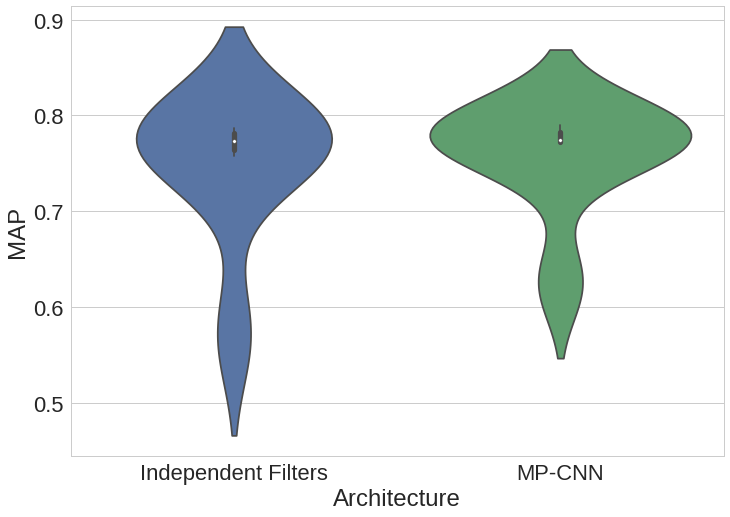

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


(0.8, 0.85)

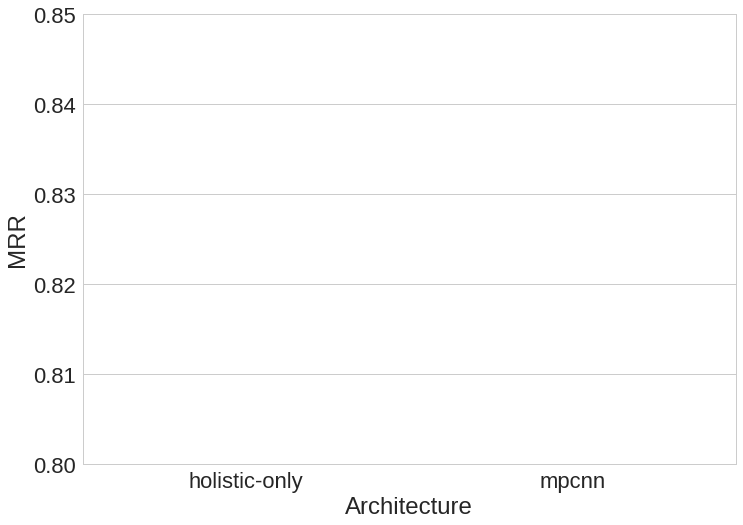

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MRR', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(0.8, 0.85)

## WikiQA

In [21]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [22]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.6408, 0.7210)
Independent Filters: (0.6522, 0.7294)


In [23]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.6489, 0.7372)
Independent Filters: (0.6592, 0.7467)


In [24]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.690800,388458.571429
MP-CNN,0.680886,388458.571429


In [25]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.702986,388458.571429
MP-CNN,0.693043,388458.571429


In [26]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: Independent Filters
Median of MAP change compared with independent filters baseline: 0.0000
Mean of MAP change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MAP change compared with independent filters baseline: -0.0104
Mean of MAP change compared with independent filters baseline: -0.0099


In [27]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: Independent Filters
Median of MRR change compared with independent filters baseline: 0.0000
Mean of MRR change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MRR change compared with independent filters baseline: -0.0111
Mean of MRR change compared with independent filters baseline: -0.0099


In [28]:
compare_change_to_baseline(wikiqa_map_vs_archs_dev, 'MAP')

Architecture: Independent Filters
Median of MAP change compared with independent filters baseline: 0.0000
Mean of MAP change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MAP change compared with independent filters baseline: -0.0058
Mean of MAP change compared with independent filters baseline: -0.0103


In [29]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_dev, 'MRR')

Architecture: Independent Filters
Median of MRR change compared with independent filters baseline: 0.0000
Mean of MRR change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of MRR change compared with independent filters baseline: -0.0038
Mean of MRR change compared with independent filters baseline: -0.0104


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

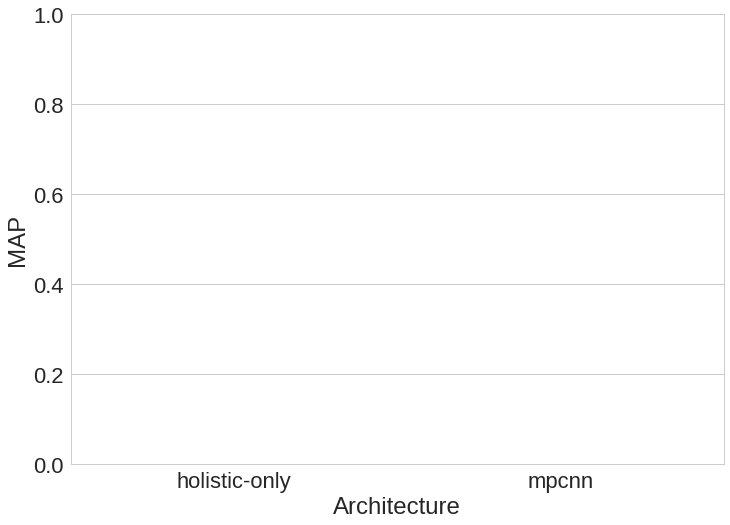

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

## SICK

In [31]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [32]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.8640, 0.8716)
Independent Filters: (0.8653, 0.8724)


In [33]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7955, 0.8089)
Independent Filters: (0.7995, 0.8094)


In [34]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.868890,388458.571429
MP-CNN,0.867799,388458.571429


In [35]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
Independent Filters,0.804474,388458.571429
MP-CNN,0.802175,388458.571429


In [36]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: Independent Filters
Median of pearson change compared with independent filters baseline: 0.0000
Mean of pearson change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of pearson change compared with independent filters baseline: -0.0009
Mean of pearson change compared with independent filters baseline: -0.0011


In [37]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: Independent Filters
Median of spearman change compared with independent filters baseline: 0.0000
Mean of spearman change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of spearman change compared with independent filters baseline: -0.0020
Mean of spearman change compared with independent filters baseline: -0.0023


In [38]:
compare_change_to_baseline(sick_pearson_vs_archs_dev, 'pearson')

Architecture: Independent Filters
Median of pearson change compared with independent filters baseline: 0.0000
Mean of pearson change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of pearson change compared with independent filters baseline: -0.0043
Mean of pearson change compared with independent filters baseline: -0.0036


In [39]:
compare_change_to_baseline(sick_spearman_vs_archs_dev, 'spearman')

Architecture: Independent Filters
Median of spearman change compared with independent filters baseline: 0.0000
Mean of spearman change compared with independent filters baseline: 0.0000
Architecture: MP-CNN
Median of spearman change compared with independent filters baseline: -0.0050
Mean of spearman change compared with independent filters baseline: -0.0037


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 6 Text yticklabel objects>)

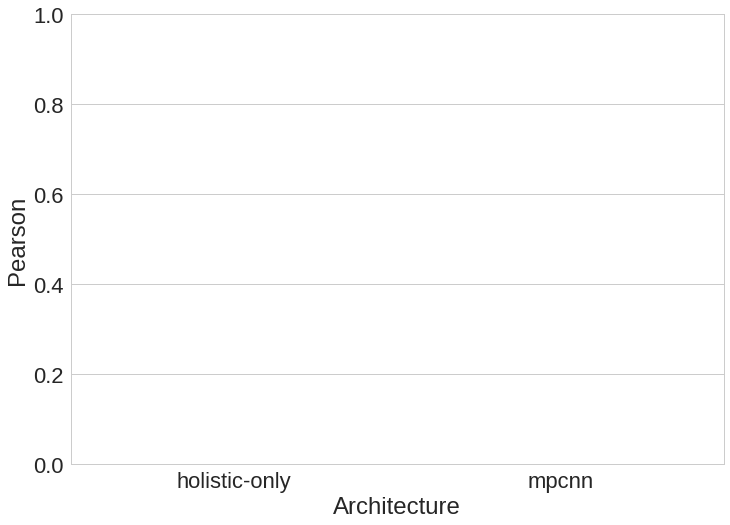

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=['holistic-only', 'mpcnn'], ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)